In [470]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import equalize_hist
from skimage.filters.ridges import frangi

from src.models import InputImage
from src.utils import create_circle_mask
from src.well import well_hough_transformation


In [471]:
fishy = InputImage("zf2.jpg")

## HOUGH TRANSFORM & CIRCLE MASK

# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________


Text(0.5, 1.0, 'mask')

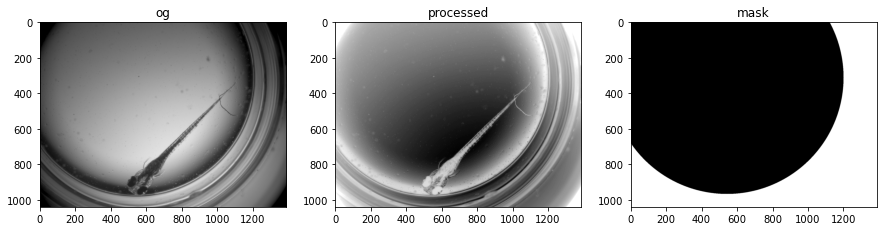

In [472]:
fishy = well_hough_transformation(fishy)
fishy = create_circle_mask(fishy, correction=8)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax = ax.ravel()

ax[0].imshow(fishy.og, 'binary')
ax[0].set_title('og')

ax[1].imshow(fishy.processed, 'binary')
ax[1].set_title('processed')

ax[2].imshow(fishy.well_props.mask.og, 'binary')
ax[2].set_title('mask')

## DEFINING MASKED IMAGES

In [473]:
from skimage.color import rgb2gray
from src.utils import get_bounding_box_obj

bbox = get_bounding_box_obj(fishy.well_props.mask.og)
fishy.well_props.bounding_box = bbox

fishy.well_props.mask.cropped = fishy.well_props.mask.og[bbox.x1:bbox.x2 + 1, bbox.y1:bbox.y2 + 1]

masked = fishy.well_props.mask.og.astype(np.uint8) * rgb2gray(fishy.og.astype(np.uint8))
fishy.well_props.mask.masked = masked
fishy.well_props.mask.cropped_masked = masked[bbox.x1:bbox.x2 + 1, bbox.y1:bbox.y2 + 1]

# Storing result
fishy.processed = fishy.well_props.mask.cropped_masked.copy()

Text(0.5, 1.0, 'cropped masked')

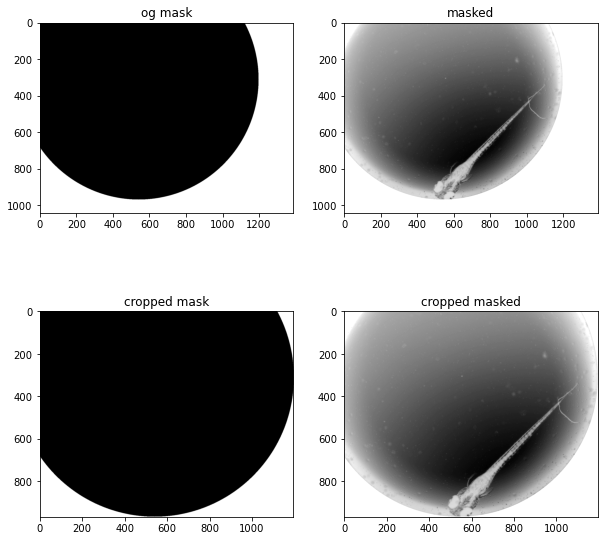

In [474]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

ax[0].imshow(fishy.well_props.mask.og, 'binary')
ax[0].set_title('og mask')

ax[1].imshow(fishy.well_props.mask.masked, 'binary')
ax[1].set_title('masked')

ax[2].imshow(fishy.well_props.mask.cropped, 'binary')
ax[2].set_title('cropped mask')

ax[3].imshow(fishy.well_props.mask.cropped_masked, 'binary')
ax[3].set_title('cropped masked')

## REMOVE BACKGROUND

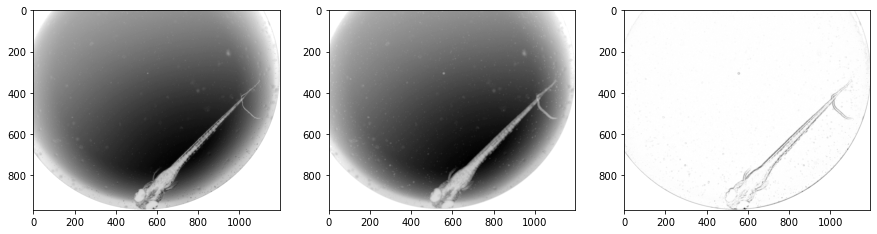

In [475]:
from skimage.exposure import equalize_adapthist
from src.filters import sharpen_img
from skimage.restoration import rolling_ball

og = fishy.well_props.mask.cropped_masked
bg = rolling_ball(og)
res = og - bg

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(og, 'binary')
ax[1].imshow(bg, 'binary')
ax[2].imshow(res, 'binary')

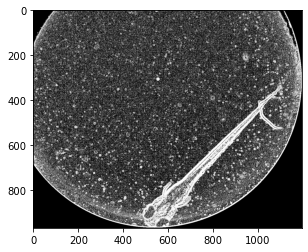

In [484]:
from skimage.feature import canny
from src.filters import sobel

res_ = (equalize_hist(res))
plt.imshow(res_, 'gray')

## YEN THRESHOLDING

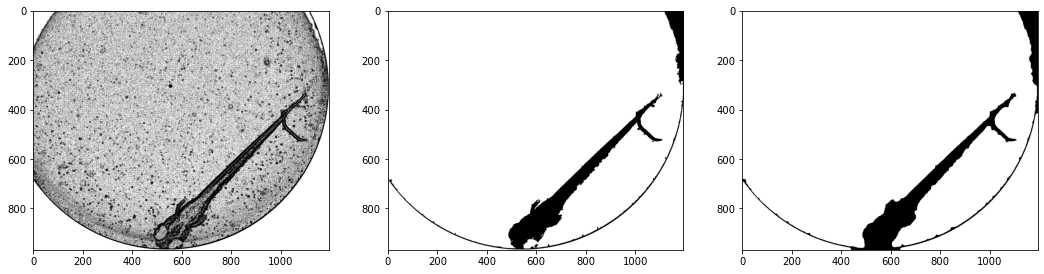

In [487]:
from src.filters import yen_th, remove_speckles
from scipy import ndimage
from skimage.morphology import remove_small_objects, binary_closing, disk, binary_opening, binary_dilation
from skimage.filters.thresholding import threshold_yen, threshold_otsu, threshold_isodata, threshold_minimum

fig, ax = plt.subplots(1, 3, figsize=(18, 12))
ax = ax.ravel()

sob = res_

sob_ = yen_th(sob)
size = sob_.size * 0.001
sob_ = remove_speckles(sob_)
sob_ = ndimage.binary_fill_holes(sob_)
sob__ = ndimage.binary_fill_holes(binary_closing(sob_, disk(10)))

ax[0].imshow(sob, 'binary')
ax[1].imshow(sob_, 'binary')
ax[2].imshow(sob__, 'binary')

{'area': array([72029]), 'label': array([1])}


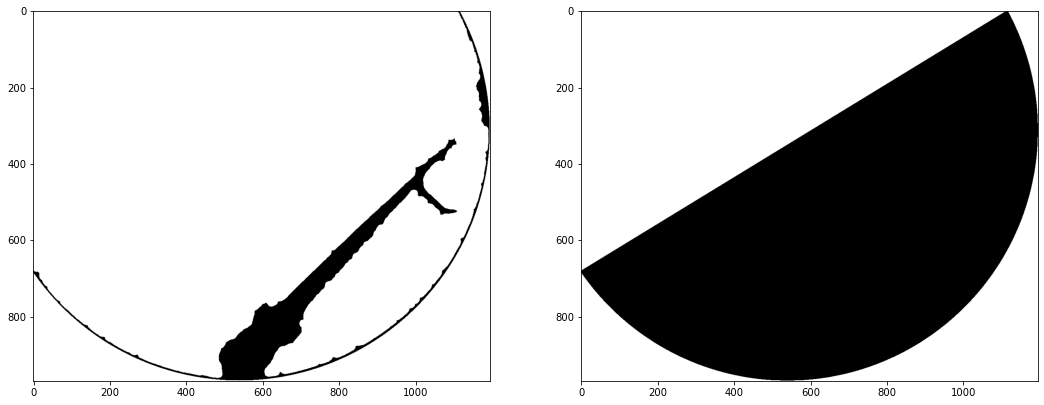

In [490]:
from src.utils import keep_largest_object
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object

fig, ax = plt.subplots(1, 2, figsize=(18, 12))
ax = ax.ravel()

klo= keep_largest_object(sob__)* fishy.well_props.mask.cropped
ax[0].imshow(klo, 'binary')
ax[1].imshow(convex_hull_object(klo), 'binary')

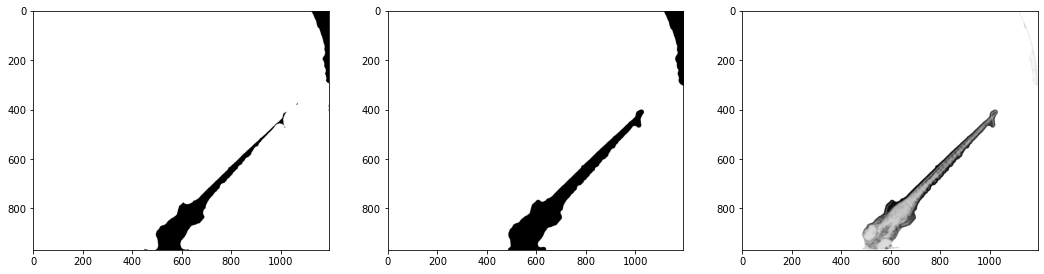

In [489]:
fig, ax = plt.subplots(1, 3, figsize=(18, 12))
ax = ax.ravel()

er = binary_erosion(sob__, disk(10))
re = remove_small_objects(er, size)
di = binary_dilation(re, disk(10))

ax[0].imshow(er, 'binary')
ax[1].imshow(di, 'binary')
ax[2].imshow(di*fishy.well_props.mask.cropped_masked, 'binary')

In [480]:
"""fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

frangi_ = frangi(sob__)
frangi__ = equalize_hist(frangi_)

ax[0].imshow(frangi_, 'binary')
ax[1].imshow(frangi__, 'binary')
ax[2].hist(frangi_.ravel())
ax[3].hist(frangi__.ravel())"""

"fig, ax = plt.subplots(2, 2, figsize=(10, 10))\nax = ax.ravel()\n\nfrangi_ = frangi(sob__)\nfrangi__ = equalize_hist(frangi_)\n\nax[0].imshow(frangi_, 'binary')\nax[1].imshow(frangi__, 'binary')\nax[2].hist(frangi_.ravel())\nax[3].hist(frangi__.ravel())"

In [481]:
"""from src.filters import yen_th

inv_enhanced_meniscus = ~yen_th(frangi__)

plt.imshow(inv_enhanced_meniscus, 'binary')"""

"from src.filters import yen_th\n\ninv_enhanced_meniscus = ~yen_th(frangi__)\n\nplt.imshow(inv_enhanced_meniscus, 'binary')"

In [482]:
"""from skimage.measure import label
from skimage.segmentation import find_boundaries

lab= label(frangi__)
boundaries = find_boundaries(inv_enhanced_meniscus)

plt.imshow(boundaries, 'binary')"""

"from skimage.measure import label\nfrom skimage.segmentation import find_boundaries\n\nlab= label(frangi__)\nboundaries = find_boundaries(inv_enhanced_meniscus)\n\nplt.imshow(boundaries, 'binary')"